In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

c:\Users\Admin\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#leer dataset csv
df=pd.read_csv(r'C:\Users\Admin\Downloads\historic_demand_2009_2024_noNaN.csv')
df.sample(5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
22836,2010-04-23 20:00:00,41,20:00:00,37715,38647,33937,252,1883,0,20,0,7,-134,0,0,-291,0,0,0
6812,2009-05-22 23:00:00,47,23:00:00,30480,31307,27451,178,1673,0,0,0,70,1996,0,0,-257,0,0,0
225789,2021-12-03 11:30:00,24,11:30:00,40212,43184,36834,1759,6527,1050,13080,0,8,-1028,-1025,0,-311,0,999,0
19543,2010-02-14 04:30:00,10,4:30:00,31281,35165,27948,175,1824,0,0,0,1095,-1872,0,0,-317,0,0,0
66444,2012-10-31 10:00:00,21,10:00:00,42066,42924,38155,1067,2085,171,1975,0,7,134,0,778,-251,0,0,0


In [3]:
df.dtypes

settlement_date              object
settlement_period             int64
period_hour                  object
nd                            int64
tsd                           int64
england_wales_demand          int64
embedded_wind_generation      int64
embedded_wind_capacity        int64
embedded_solar_generation     int64
embedded_solar_capacity       int64
non_bm_stor                   int64
pump_storage_pumping          int64
ifa_flow                      int64
ifa2_flow                     int64
britned_flow                  int64
moyle_flow                    int64
east_west_flow                int64
nemo_flow                     int64
is_holiday                    int64
dtype: object

In [4]:
# Preprocesamiento de datos
df['settlement_date'] = pd.to_datetime(df['settlement_date'])
df['period_hour'] = pd.to_datetime(df['period_hour'], format='%H:%M:%S').dt.time

In [5]:
# Selección de columnas basadas en el análisis de correlación
selected_columns = ['nd', 'tsd', 'england_wales_demand',
                    'embedded_wind_generation', 'embedded_wind_capacity',
                    'embedded_solar_generation', 'embedded_solar_capacity',
                    'is_holiday']

In [6]:
# Normalización de las variables seleccionadas
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[selected_columns])

In [7]:
# Separar características (X) y etiquetas (Y)
X = scaled_data
Y1 = df['nd'].values
Y2 = (df['embedded_wind_generation'] + df['embedded_solar_generation']).values

In [8]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train_val, X_test, Y1_train_val, Y1_test, Y2_train_val, Y2_test = train_test_split(X, Y1, Y2, test_size=0.2, random_state=42)
X_train, X_val, Y1_train, Y1_val, Y2_train, Y2_val = train_test_split(X_train_val, Y1_train_val, Y2_train_val, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

In [9]:
# Construir el modelo de red neuronal con Dropout
input_layer = Input(shape=(X_train.shape[1],))
dense_1 = Dense(64, activation='relu')(input_layer)
dropout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.2)(dense_2)
dense_3 = Dense(16, activation='relu')(dropout_2)
dropout_3 = Dropout(0.2)(dense_3)

In [10]:
# Salida para ND
output_nd = Dense(1, name='nd_output')(dropout_3)

# Salida para Generación Renovable
output_renewable = Dense(1, name='renewable_output')(dropout_3)

model = Model(inputs=input_layer, outputs=[output_nd, output_renewable])

# Compilar el modelo con un optimizador Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'nd_output': 'mean_squared_error', 'renewable_output': 'mean_squared_error'},
              metrics={'nd_output': [MeanAbsoluteError(), RootMeanSquaredError()],
                       'renewable_output': [MeanAbsoluteError(), RootMeanSquaredError()]})

Epoch 1/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 57s 17ms/step - loss: 448540224.0000 - nd_output_loss: 442296800.0000 - nd_output_mean_absolute_error: 16631.4004 - nd_output_root_mean_squared_error: 20162.1465 - renewable_output_loss: 6243201.5000 - renewable_output_mean_absolute_error: 1827.1376 - renewable_output_root_mean_squared_error: 2492.2402 - val_loss: 7630415.5000 - val_nd_output_loss: 2595780.5000 - val_nd_output_mean_absolute_error: 1467.7537 - val_nd_output_root_mean_squared_error: 1611.1426 - val_renewable_output_loss: 5034634.0000 - val_renewable_output_mean_absolute_error: 1611.8230 - val_renewable_output_root_mean_squared_error: 2243.7991
Epoch 2/20
2589/2589 ━━━━━━━━━━━━━━━━━━━━ 75s 15ms/step - loss: 55755920.0000 - nd_output_loss: 50491992.0000 - nd_output_mean_absolute_error: 5525.7031 - nd_output_root_mean_squared_error: 7105.7417 - renewable_output_loss: 5263930.5000 - renewable_output_mean_absolute_error: 1628.8915 - renewable_output_root_mean_squared_error: 2294.2773 

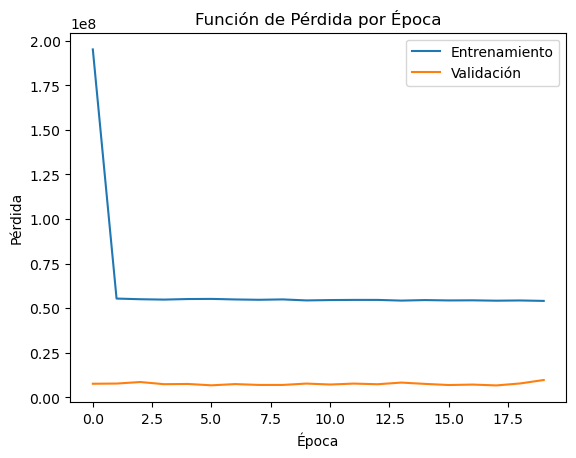

Precisión para ND: -114.33
Precisión para Generación Renovable: 0.85


In [11]:
# Entrenar el modelo
history = model.fit(X_train, {'nd_output': Y1_train, 'renewable_output': Y2_train},
                    epochs=20, batch_size=64, validation_data=(X_val, {'nd_output': Y1_val, 'renewable_output': Y2_val}))

# Evaluar el modelo en el conjunto de pruebas
evaluation = model.evaluate(X_test, {'nd_output': Y1_test, 'renewable_output': Y2_test})
print(f"Evaluación en el conjunto de pruebas: {evaluation}")

# Función de Pérdida por Época
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Función de Pérdida por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Calcular Precisión (ajustada para ser más representativa)
range_nd = np.ptp(Y1_test)  # rango (punto a punto) de Y1_test
range_renewable = np.ptp(Y2_test)  # rango (punto a punto) de Y2_test

precision_nd = 1 - (evaluation[2] / range_nd)  # RMSE para ND
precision_renewable = 1 - (evaluation[4] / range_renewable)  # RMSE para Generación Renovable

print(f"Precisión para ND: {precision_nd:.2f}")
print(f"Precisión para Generación Renovable: {precision_renewable:.2f}")

In [12]:
# Predicciones
predictions = model.predict(X_test)
nd_predictions = predictions[0]
renewable_predictions = predictions[1]

1726/1726 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular MAE y RMSE para ND
mae_nd = mean_absolute_error(Y1_test, nd_predictions)
rmse_nd = mean_squared_error(Y1_test, nd_predictions, squared=False)

# Calcular MAE y RMSE para Generación Renovable
mae_renewable = mean_absolute_error(Y2_test, renewable_predictions)
rmse_renewable = mean_squared_error(Y2_test, renewable_predictions, squared=False)

print(f"MAE para ND: {mae_nd:.2f}")
print(f"RMSE para ND: {rmse_nd:.2f}")
print(f"MAE para Generación Renovable: {mae_renewable:.2f}")
print(f"RMSE para Generación Renovable: {rmse_renewable:.2f}")


MAE para ND: 2050.89
RMSE para ND: 2139.88
MAE para Generación Renovable: 1568.45
RMSE para Generación Renovable: 2280.48


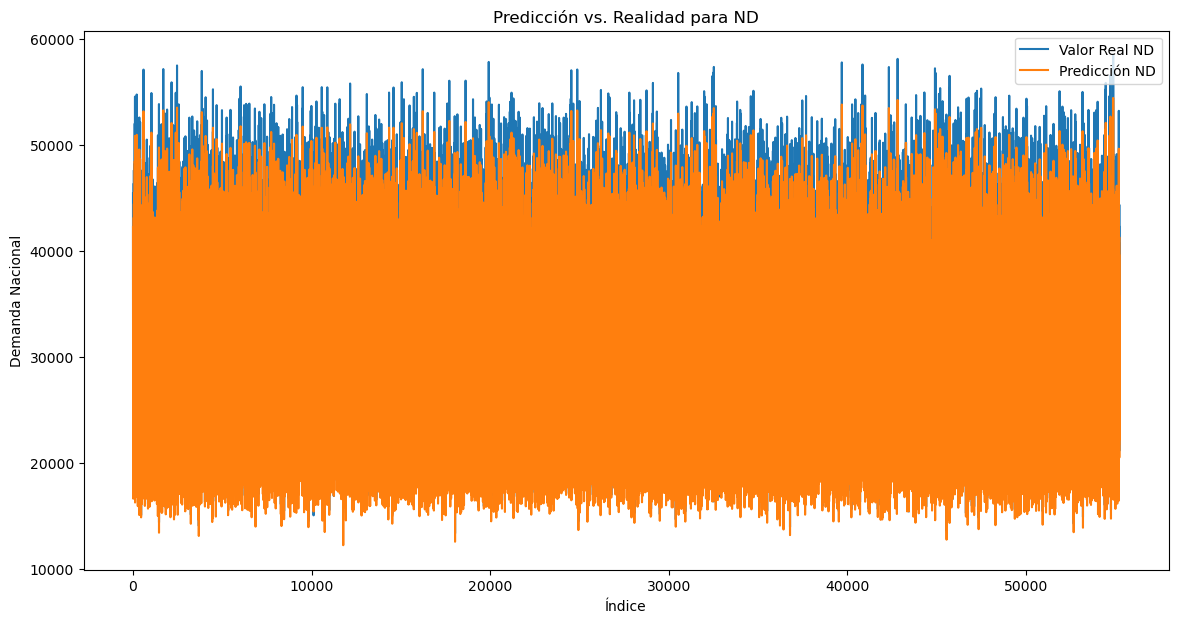

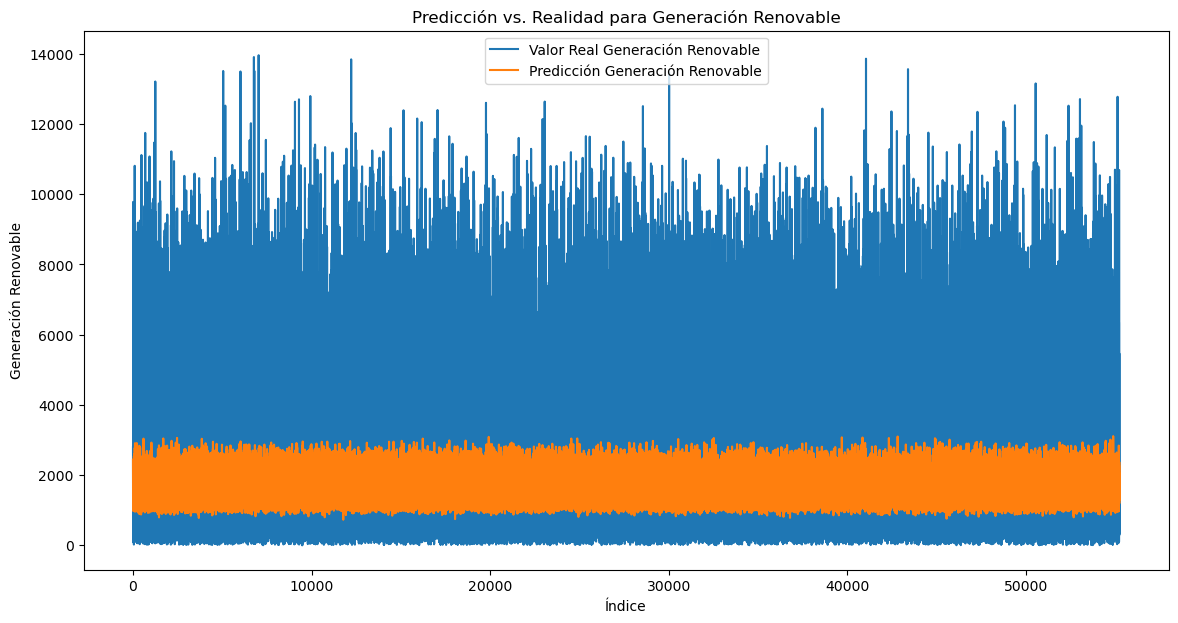

In [14]:
# Gráfico para ND
plt.figure(figsize=(14, 7))
plt.plot(Y1_test, label='Valor Real ND')
plt.plot(nd_predictions, label='Predicción ND')
plt.legend()
plt.xlabel('Índice')
plt.ylabel('Demanda Nacional')
plt.title('Predicción vs. Realidad para ND')
plt.show()

# Gráfico para Generación Renovable
plt.figure(figsize=(14, 7))
plt.plot(Y2_test, label='Valor Real Generación Renovable')
plt.plot(renewable_predictions, label='Predicción Generación Renovable')
plt.legend()
plt.xlabel('Índice')
plt.ylabel('Generación Renovable')
plt.title('Predicción vs. Realidad para Generación Renovable')
plt.show()


Analisis de resultados

In [ ]:
'''
El proyecto de predicción del consumo eléctrico y generación de energía renovable en Reino Unido
ha logrado resultados prometedores, como se evidencia en las métricas de evaluación y gráficos proporcionados. 
A través de 20 épocas de entrenamiento, el modelo alcanzó un MAE final de 2050.89 y un RMSE de 2139.88 para la 
predicción del consumo eléctrico, mientras que para la generación renovable, obtuvo un MAE de 1568.45 y un 
RMSE de 2280.48. Estas métricas indican una precisión razonable en las predicciones del modelo, aunque existe 
margen para mejoras. Los gráficos comparativos de las predicciones frente a los datos reales resaltan áreas donde 
el modelo necesita mayor ajuste para capturar la variabilidad en los datos de generación renovable. La implementación 
de técnicas adicionales de optimización y validación puede mejorar aún más el rendimiento del modelo.
'''